<a href="https://colab.research.google.com/github/Kneicik/Paluszki/blob/main/Cechy_globalnie_i_lokalnie_Lato2024.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
class Minutia:
    def __init__(self, locX, locY, orientation, minutiaType, closestNeighbor = None, secondClosestNeighbor = None, featureVector = None, globalFeatureVector = None):
        self.locX = locX
        self.locY = locY
        self.orientation = orientation
        self.minutiaType = minutiaType # 0 - Termination; 1 - Bifurcation
        self.closestNeighbor = closestNeighbor
        self.secondClosestNeighbor = secondClosestNeighbor
        self.featureVector = featureVector
        self.globalFeatureVector = globalFeatureVector

    def __str__(self):
        return "locX:\t\t" + str(self.locX) + "\n" \
        + "locY:\t\t" + str(self.locY) + "\n" \
        + "orientation:\t" + str(self.orientation) + "\n" \
        + "minutiaType:\t" + str(self.minutiaType) + "\n" \
        + "closestNeighbor:\t" + str(self.closestNeighbor) + "\n" \
        + "secondClosestNeighbor:\t" + str(self.secondClosestNeighbor) + "\n" \
        + "featureVector:\t\t" + str(self.featureVector) + "\n" \
        + "globalFeatureVector:\t\t" + str(self.globalFeatureVector)

In [ ]:
import cv2
import numpy as np
import skimage.morphology
from skimage.morphology import convex_hull_image, erosion
from skimage.morphology import square
import math

class MinutiaeFeature(object):
    def __init__(self, locX, locY, Orientation, Type):
        self.locX = locX
        self.locY = locY
        self.Orientation = Orientation
        self.Type = Type

class FingerprintFeatureExtractor(object):
    def __init__(self):
        self._mask = []
        self._skel = []
        self.minutiaeTerm = []
        self.minutiaeBif = []
        self._spuriousMinutiaeThresh = 20

    def setSpuriousMinutiaeThresh(self, spuriousMinutiaeThresh):
        self._spuriousMinutiaeThresh = spuriousMinutiaeThresh

    def __skeletonize(self, img):
        img = np.uint8(img > 128)
        self._skel = skimage.morphology.skeletonize(img)
        self._skel = np.uint8(self._skel) * 255
        self._mask = img * 255

    def __computeAngle(self, block, minutiaeType):
        angle = []
        (blkRows, blkCols) = np.shape(block)
        CenterX, CenterY = (blkRows - 1) / 2, (blkCols - 1) / 2
        if (minutiaeType.lower() == 'termination'):
            sumVal = 0
            for i in range(blkRows):
                for j in range(blkCols):
                    if ((i == 0 or i == blkRows - 1 or j == 0 or j == blkCols - 1) and block[i][j] != 0):
                        angle.append(-math.degrees(math.atan2(i - CenterY, j - CenterX)))
                        sumVal += 1
                        if (sumVal > 1):
                            angle.append(float('nan'))
            return (angle)

        elif (minutiaeType.lower() == 'bifurcation'):
            (blkRows, blkCols) = np.shape(block)
            CenterX, CenterY = (blkRows - 1) / 2, (blkCols - 1) / 2
            angle = []
            sumVal = 0
            for i in range(blkRows):
                for j in range(blkCols):
                    if ((i == 0 or i == blkRows - 1 or j == 0 or j == blkCols - 1) and block[i][j] != 0):
                        angle.append(-math.degrees(math.atan2(i - CenterY, j - CenterX)))
                        sumVal += 1
            if (sumVal != 3):
                angle.append(float('nan'))
            return (angle)

    def __getTerminationBifurcation(self):
        self._skel = self._skel == 255
        (rows, cols) = self._skel.shape
        self.minutiaeTerm = np.zeros(self._skel.shape)
        self.minutiaeBif = np.zeros(self._skel.shape)

        for i in range(1, rows - 1):
            for j in range(1, cols - 1):
                if (self._skel[i][j] == 1):
                    block = self._skel[i - 1:i + 2, j - 1:j + 2]
                    block_val = np.sum(block)
                    if (block_val == 2):
                        self.minutiaeTerm[i, j] = 1
                    elif (block_val == 4):
                        self.minutiaeBif[i, j] = 1

        self._mask = convex_hull_image(self._mask > 0)
        self._mask = erosion(self._mask, square(5))  # Structuing element for mask erosion = square(5)
        self.minutiaeTerm = np.uint8(self._mask) * self.minutiaeTerm

    def __removeSpuriousMinutiae(self, minutiaeList, img):
        img = img * 0
        SpuriousMin = []
        numPoints = len(minutiaeList)
        D = np.zeros((numPoints, numPoints))
        for i in range(1,numPoints):
            for j in range(0, i):
                (X1,Y1) = minutiaeList[i]['centroid']
                (X2,Y2) = minutiaeList[j]['centroid']

                dist = np.sqrt((X2-X1)**2 + (Y2-Y1)**2)
                D[i][j] = dist
                if(dist < self._spuriousMinutiaeThresh):
                    SpuriousMin.append(i)
                    SpuriousMin.append(j)

        SpuriousMin = np.unique(SpuriousMin)
        for i in range(0,numPoints):
            if(not i in SpuriousMin):
                (X,Y) = np.int16(minutiaeList[i]['centroid'])
                img[X,Y] = 1

        img = np.uint8(img)
        return(img)

    def __cleanMinutiae(self, img):
        self.minutiaeTerm = skimage.measure.label(self.minutiaeTerm, connectivity=2)
        RP = skimage.measure.regionprops(self.minutiaeTerm)
        self.minutiaeTerm = self.__removeSpuriousMinutiae(RP, np.uint8(img))

    def __performFeatureExtraction(self):
        FeaturesTerm = []
        self.minutiaeTerm = skimage.measure.label(self.minutiaeTerm, connectivity=2)
        RP = skimage.measure.regionprops(np.uint8(self.minutiaeTerm))

        WindowSize = 2  # --> For Termination, the block size must can be 3x3, or 5x5. Hence the window selected is 1 or 2
        FeaturesTerm = []
        for num, i in enumerate(RP):
            (row, col) = np.int16(np.round(i['Centroid']))
            block = self._skel[row - WindowSize:row + WindowSize + 1, col - WindowSize:col + WindowSize + 1]
            angle = self.__computeAngle(block, 'Termination')
            if(len(angle) == 1):
                FeaturesTerm.append(MinutiaeFeature(row, col, angle, 'Termination'))

        FeaturesBif = []
        self.minutiaeBif = skimage.measure.label(self.minutiaeBif, connectivity=2)
        RP = skimage.measure.regionprops(np.uint8(self.minutiaeBif))
        WindowSize = 1  # --> For Bifurcation, the block size must be 3x3. Hence the window selected is 1
        for i in RP:
            (row, col) = np.int16(np.round(i['Centroid']))
            block = self._skel[row - WindowSize:row + WindowSize + 1, col - WindowSize:col + WindowSize + 1]
            angle = self.__computeAngle(block, 'Bifurcation')
            if(len(angle) == 3):
                FeaturesBif.append(MinutiaeFeature(row, col, angle, 'Bifurcation'))
        return (FeaturesTerm, FeaturesBif)

    def extractMinutiaeFeatures(self, img):
        self.__skeletonize(img)

        self.__getTerminationBifurcation()

        self.__cleanMinutiae(img)

        FeaturesTerm, FeaturesBif = self.__performFeatureExtraction()
        return(FeaturesTerm, FeaturesBif)

    def showResults(self, FeaturesTerm, FeaturesBif):

        (rows, cols) = self._skel.shape
        DispImg = np.zeros((rows, cols, 3), np.uint8)
        DispImg[:, :, 0] = 255*self._skel
        DispImg[:, :, 1] = 255*self._skel
        DispImg[:, :, 2] = 255*self._skel

        for idx, curr_minutiae in enumerate(FeaturesTerm):
            row, col = curr_minutiae.locX, curr_minutiae.locY
            (rr, cc) = skimage.draw.circle_perimeter(row, col, 3)
            skimage.draw.set_color(DispImg, (rr, cc), (0, 0, 255))

        for idx, curr_minutiae in enumerate(FeaturesBif):
            row, col = curr_minutiae.locX, curr_minutiae.locY
            (rr, cc) = skimage.draw.circle_perimeter(row, col, 3)
            skimage.draw.set_color(DispImg, (rr, cc), (255, 0, 0))

        cv2_imshow(DispImg)
      # cv2.imshow('output', DispImg)
        cv2.waitKey(0)

    def saveResult(self, FeaturesTerm, FeaturesBif):
        (rows, cols) = self._skel.shape
        DispImg = np.zeros((rows, cols, 3), np.uint8)
        DispImg[:, :, 0] = 255 * self._skel
        DispImg[:, :, 1] = 255 * self._skel
        DispImg[:, :, 2] = 255 * self._skel

        for idx, curr_minutiae in enumerate(FeaturesTerm):
            row, col = curr_minutiae.locX, curr_minutiae.locY
            (rr, cc) = skimage.draw.circle_perimeter(row, col, 3)
            skimage.draw.set_color(DispImg, (rr, cc), (0, 0, 255))

        for idx, curr_minutiae in enumerate(FeaturesBif):
            row, col = curr_minutiae.locX, curr_minutiae.locY
            (rr, cc) = skimage.draw.circle_perimeter(row, col, 3)
            skimage.draw.set_color(DispImg, (rr, cc), (255, 0, 0))
        cv2.imwrite('result.png', DispImg)
        cv2_imshow(DispImg)

def extract_minutiae_features(img, spuriousMinutiaeThresh=10, invertImage=False, showResult=False, saveResult=False):
    feature_extractor = FingerprintFeatureExtractor()
    feature_extractor.setSpuriousMinutiaeThresh(spuriousMinutiaeThresh)
    if (invertImage):
        img = 255 - img;

    FeaturesTerm, FeaturesBif = feature_extractor.extractMinutiaeFeatures(img)

    if (saveResult):
        feature_extractor.saveResult(FeaturesTerm, FeaturesBif)

    if(showResult):
        feature_extractor.showResults(FeaturesTerm, FeaturesBif)

    return(FeaturesTerm, FeaturesBif)

In [ ]:
!pip install fingerprint_feature_extractor
!pip install fingerprint_enhancer
#!pip install Minutia

  Preparing metadata (setup.py) ... done
  Created wheel for fingerprint_feature_extractor: filename=fingerprint_feature_extractor-0.0.10-py3-none-any.whl size=4831 sha256=e06595c8d7a92601f0735b35f1d96239ec957d11204b6ffb7f145bf5e74bb2f0
  Stored in directory: /root/.cache/pip/wheels/ad/fc/d9/ce6a90506bdff6f93044b68e229602e5b9dece43e0b9fa1d6f
Successfully built fingerprint_feature_extractor
  Preparing metadata (setup.py) ... done
  Created wheel for fingerprint_enhancer: filename=fingerprint_enhancer-0.0.13-py3-none-any.whl size=8906 sha256=7f1d10afeca94aeaab1a4a5c282f5e22abb2272348750d12394ee5456ad927e5
  Stored in directory: /root/.cache/pip/wheels/91/ae/50/978165dd230375061475f4594febfe8a42869c4cc5374f9740
Successfully built fingerprint_enhancer


Dopasowanie na podstawie cech lokalnych

In [ ]:
import fingerprint_feature_extractor
import fingerprint_enhancer
import cv2
import math
import heapq
from google.colab.patches import cv2_imshow
#from Minutia import Minutia
import matplotlib.pyplot as plt


# Calculate the difference between two angles in radians
def angleDifference(t1, t2):
    if t1 - t2 > -math.pi and t1-t2 <= math.pi:
        return t1-t2
    elif t1 - t2 <= -math.pi:
        return 2 * math.pi + t1 - t2
    else:
        return 2 * math.pi - t1 + t2

# equation 3
# Calculate the Euclidean distance between point1 (x1, y1) and point2 (x2, y2)
def euclideanDistance(x1, y1, x2, y2):
    return math.sqrt((x2 - x1)**2 + (y2 - y1)**2)

# equation 4
# calculate the relative radial angle
def radialAngle(x1, y1, orientation1 ,x2, y2):
    if abs(x1 - x2) != 0:
        return angleDifference(math.atan((y1 - y2)/(x1 - x2)), orientation1)
    else:
        if (y1 - y2 >= 0):
            return angleDifference(math.pi/2, orientation1)
        else:
            return angleDifference(-math.pi/2, orientation1)

# equation 5
# calculate the relative direction
def minutiaDirection(orientation1, orientation2):
    return angleDifference(orientation1, orientation2)

# Find the TWO nearest minutia neighbors for each given minutia
def findMinutiaNeighbors(minutiaeList):
    # needleMinutia is the minutia for which we're searching its closest neighbors
    # needleIndex is its index in the minutiaeList
    for needleIndex, needleMinutia in enumerate(minutiaeList):
        # here we go over all the minutia in the minutiaeList and we calculate the euclidean
        # distance between it and our needle minutia and store the results in a dictionary
        minutiaIndexAndDistance = {}
        for index, minutia in enumerate(minutiaeList):
            distance = euclideanDistance(minutia.locX, minutia.locY, needleMinutia.locX, needleMinutia.locY)
            # if the euclidean distance is equal to 0, that means that the needleMinutia and minutia are
            # the same object. Therefore we don't add its distance to the list
            if distance != 0:
                minutiaIndexAndDistance[index] = distance

        # now we take the two closest neighbors to our needleMinutia based on the values that
        # are stored in our minutiaIndexAndDistance dictionary
        twoClosestNeighbors = heapq.nsmallest(2, minutiaIndexAndDistance.items(), key=lambda x: x[1])
        minutiaeList[needleIndex].closestNeighbor = twoClosestNeighbors[0][0]
        minutiaeList[needleIndex].secondClosestNeighbor = twoClosestNeighbors[1][0]

# equation 6
def ComputeFeatureVectors(minutiaeList):
    for index, minutia in enumerate(minutiaeList):
        tempFeatureVector = {}
        # Compute euclidean distance for nearest neighbor (neighbor-i) and second nearest neighbor (neighbor-j)
        tempFeatureVector["d_ki"] = euclideanDistance(minutia.locX, minutia.locY, \
            minutiaeList[minutia.closestNeighbor].locX, minutiaeList[minutia.closestNeighbor].locY)
        tempFeatureVector["d_kj"] = euclideanDistance(minutia.locX, minutia.locY, \
            minutiaeList[minutia.secondClosestNeighbor].locX, minutiaeList[minutia.secondClosestNeighbor].locY)
        # Compute relative radial angle for nearest neighbor (neighbor-i) and second nearest neighbor (neighbor-j)
        tempFeatureVector["theta_ki"] = radialAngle(minutia.locX, minutia.locY, minutia.orientation, \
            minutiaeList[minutia.closestNeighbor].locX, minutiaeList[minutia.closestNeighbor].locY)
        tempFeatureVector["theta_kj"] = radialAngle(minutia.locX, minutia.locY, minutia.orientation, \
            minutiaeList[minutia.secondClosestNeighbor].locX, minutiaeList[minutia.secondClosestNeighbor].locY)
        # Compute relative direction for nearest neighbor (neighbor-i) and second nearest neighbor (neighbor-j)
        tempFeatureVector["phi_ki"] = minutiaDirection(minutia.orientation, minutiaeList[minutia.closestNeighbor].orientation)
        tempFeatureVector["phi_kj"] = minutiaDirection(minutia.orientation, minutiaeList[minutia.secondClosestNeighbor].orientation)
        # Determine the minutia type for nearest neighbor (neighbor-i) and second nearest neighbor (neighbor-j)
        tempFeatureVector["t_k"] = minutia.minutiaType
        tempFeatureVector["t_i"] = minutiaeList[minutia.closestNeighbor].minutiaType
        tempFeatureVector["t_j"] = minutiaeList[minutia.secondClosestNeighbor].minutiaType

        minutiaeList[index].featureVector = tempFeatureVector

def ComputeGlobalFeatureVectors(minutiaeList, referenceMinutiae):
    for index, minutia in enumerate(minutiaeList):
        tempFeatureVector = {}
        tempFeatureVector["r_kb"] = euclideanDistance(referenceMinutiae.locX, referenceMinutiae.locY, \
            minutia.locX, minutia.locY)
        tempFeatureVector["theta_kb"] = radialAngle(minutia.locX, minutia.locY, referenceMinutiae.orientation, \
            referenceMinutiae.locX, referenceMinutiae.locY)
        tempFeatureVector["phi_kb"] = minutiaDirection(minutia.orientation, referenceMinutiae.orientation)

        minutiaeList[index].globalFeatureVector = tempFeatureVector

def computeVectorMagnitude(vector):
    sum = 0
    for key, value in vector.items():
        sum += value**2
    return math.sqrt(sum)

# equation 7
# compares a minutiae pair from the inputImage and templateImage. A value of 1 indicates a full match and a value of 0 indicates no match
# porównuje parę minucji z inputImage i templateImage. Wartość 1 oznacza pełne dopasowanie, a wartość 0 oznacza brak dopasowania
def compareLocalStructures(inputFeatureVector, templateFeatureVector):
    weights = {"d_ki":1, "d_kj":1, "theta_ki":0.3*180/math.pi, "theta_kj":0.3*180/math.pi, \
        "phi_ki":0.3*180/math.pi, "phi_kj":0.3*180/math.pi, "t_k":3, "t_i": 3, "t_j":3}
    m = len(weights)
    bl = 6 * m

    vector = {}
    features = ["d_ki", "d_kj", "t_k", "t_i", "t_j"]
    for feature in features:
        vector[feature] = (inputFeatureVector[feature] - templateFeatureVector[feature]) * weights[feature]
    angles = ["theta_ki", "theta_kj", "phi_ki", "phi_kj"]
    for angle in angles:
        vector[angle] = angleDifference(inputFeatureVector[angle], templateFeatureVector[angle]) * weights[angle]
    vectorMagnitude = computeVectorMagnitude(vector)
    if bl > vectorMagnitude:
        return (bl - vectorMagnitude) / bl
    else:
        return 0


# equation 9
# find a pair of minutiae with the highest similarity
# znajdź parę minucji o największym podobieństwie
def findBestMatch(inputMinutiaeList, templateMinutiaeList):
    bestMatch = {}
    maxSimilarity = -1

    for inputMinutia in inputMinutiaeList:
        for templateMinutia in templateMinutiaeList:
            similarity = compareLocalStructures(inputMinutia.featureVector, templateMinutia.featureVector)
            if (similarity > maxSimilarity):
                bestMatch["inputMinutia"] = inputMinutia
                bestMatch["templateMinutia"] = templateMinutia
                bestMatch["similarity"] = similarity
                maxSimilarity = similarity
    return bestMatch


# Load the fingerprint images
inputImg = cv2.imread("fingerprints/finger_1/101_1.tif", 0)
templateImg = cv2.imread("fingerprints/finger_1/101_5.tif", 0)
#inputImg = cv2.imread("./fingerprints/1.tif", 0)
#templateImg = cv2.imread("./fingerprints/2.tif", 0)



# Enhance the images (may throw an exception for low dpi images)
# Popraw obrazy (może zgłosić wyjątek dla obrazów o niskiej rozdzielczości)
enInputImg = fingerprint_enhancer.enhance_Fingerprint(inputImg)
enTemplateImg = fingerprint_enhancer.enhance_Fingerprint(templateImg)

# Extract the features from the fingerprint image
# Wyodrębnij cechy z obrazu odcisku palca
inputFeaturesTerminations, inputFeaturesBifurcations = fingerprint_feature_extractor.extract_minutiae_features(enInputImg, spuriousMinutiaeThresh=20, invertImage=False, showResult=False, saveResult=True)
inputRes = cv2.imread("./result.png", cv2.IMREAD_COLOR)
templateFeaturesTerminations, templateFeaturesBifurcations = fingerprint_feature_extractor.extract_minutiae_features(enTemplateImg, spuriousMinutiaeThresh=20, invertImage=False, showResult=False, saveResult=True)
templateRes = cv2.imread("./result.png", cv2.IMREAD_COLOR)

# Create a list of minutiae features (x location, y location, orientation in degrees, type)
# Utwórz listę minucji (lokalizacja x, lokalizacja y, orientacja w stopniach, typ)
inputMinutiaeList = []
templateMinutiaeList = []
for term in inputFeaturesTerminations:
    inputMinutiaeList.append(Minutia(term.locX, term.locY, math.radians(term.Orientation[0]), 0))
for bif in inputFeaturesBifurcations:
    inputMinutiaeList.append(Minutia(bif.locX, bif.locY, math.radians(bif.Orientation[0]), 1))

for term in templateFeaturesTerminations:
    templateMinutiaeList.append(Minutia(term.locX, term.locY, math.radians(term.Orientation[0]), 0))
for bif in templateFeaturesBifurcations:
    templateMinutiaeList.append(Minutia(bif.locX, bif.locY, math.radians(bif.Orientation[0]), 1))

#Znajdź dwóch najbliższych sąsiadów dla każdej minucji
# Find two nearest neighbors for each minutia
findMinutiaNeighbors(inputMinutiaeList)
findMinutiaNeighbors(templateMinutiaeList)

# Oblicz wektor cech dla każdej minucji
ComputeFeatureVectors(inputMinutiaeList)
ComputeFeatureVectors(templateMinutiaeList)

i = 0
sum = 0
am = min(len(inputMinutiaeList), len(templateMinutiaeList))-3
while i < am:
    bestMatch = findBestMatch(inputMinutiaeList, templateMinutiaeList)
     #print(bestMatch["inputMinutia"])
     #print(bestMatch["templateMinutia"])
    inputMinutiaeList.remove(bestMatch['inputMinutia'])
    templateMinutiaeList.remove(bestMatch['templateMinutia'])
    sum += bestMatch['similarity']
    i += 1
    # Find two nearest neighbors for each minutia
    findMinutiaNeighbors(inputMinutiaeList)
    findMinutiaNeighbors(templateMinutiaeList)

    # Compute the feature vector for each minutia
    ComputeFeatureVectors(inputMinutiaeList)
    ComputeFeatureVectors(templateMinutiaeList)


print("Best Match Details:")
print("Input Minutia:", bestMatch["inputMinutia"].__dict__)
print("Template Minutia:"bestMatch["templateMinutia"].__dict__)

print("Liczba dopasowań", am)
print("Punktacja na podstawie cech lokalnych {:.3f}".format(sum/am))
cv2_imshow(inputImg)
cv2_imshow(inputRes)
cv2_imshow(templateImg)
cv2_imshow(templateRes)

Best Match Details:
Input Minutia: {'locX': 113, 'locY': 278, 'orientation': 2.677945044588987, 'minutiaType': 0, 'closestNeighbor': 1, 'secondClosestNeighbor': 2, 'featureVector': {'d_ki': 63.00793600809346, 'd_kj': 168.62087652482418, 'theta_ki': 2.977610836789105, 'theta_kj': -3.1256788777411857, 'phi_ki': 0.32175055439664213, 'phi_kj': 0.46364760900080615, 't_k': 0, 't_i': 1, 't_j': 1}, 'globalFeatureVector': None}


TypeError: unsupported format string passed to dict.__format__

In [ ]:
#from google.colab import drive
#drive.mount('/content/drive')

# Nowa sekcja

Global

# Dopasowywanie odcisków palców na podstawie
struktur lokalnych i globalnych minucji

Best Match Details:
Input Minutia: {'locX': 164, 'locY': 241, 'orientation': 2.356194490192345, 'minutiaType': 1, 'closestNeighbor': 13, 'secondClosestNeighbor': 11, 'featureVector': {'d_ki': 42.04759208325728, 'd_kj': 54.817880294662984, 'theta_ki': -2.3086113869153615, 'theta_kj': 2.6144467100033832, 'phi_ki': 3.141592653589793, 'phi_kj': 0.7853981633974483, 't_k': 1, 't_i': 0, 't_j': 0}, 'globalFeatureVector': None}
Template Minutia: {'locX': 80, 'locY': 241, 'orientation': 2.356194490192345, 'minutiaType': 1, 'closestNeighbor': 3, 'secondClosestNeighbor': 2, 'featureVector': {'d_ki': 39.05124837953327, 'd_kj': 52.392747589718944, 'theta_ki': -2.4074316575957635, 'theta_kj': 2.5872851573882416, 'phi_ki': 3.141592653589793, 'phi_kj': 0.7853981633974483, 't_k': 1, 't_i': 0, 't_j': 0}, 'globalFeatureVector': None}
Similarity: 0.9215143752367504
Punktacja na podstawie cech globalnych: 0.260


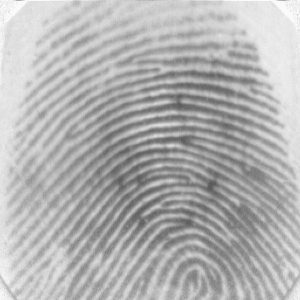

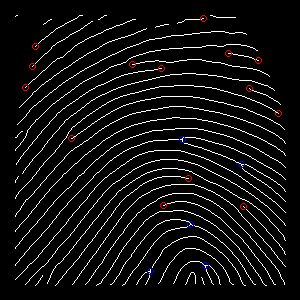

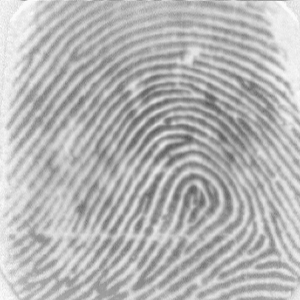

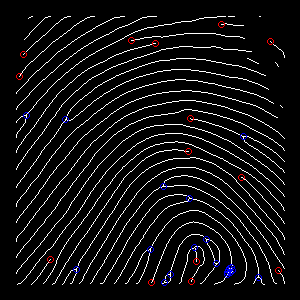

In [ ]:
import fingerprint_feature_extractor
import fingerprint_enhancer
import cv2
import math
import heapq
#from Minutia import Minutia


# Calculate the difference between two angles in radians
def angleDifference(t1, t2):
    if t1 - t2 > -math.pi and t1-t2 <= math.pi:
        return t1-t2
    elif t1 - t2 <= -math.pi:
        return 2 * math.pi + t1 - t2
    else:
        return 2 * math.pi - t1 + t2

# equation 3
# Calculate the Euclidean distance between point1 (x1, y1) and point2 (x2, y2)
def euclideanDistance(x1, y1, x2, y2):
    return math.sqrt((x2 - x1)**2 + (y2 - y1)**2)

# equation 4
# calculate the relative radial angle
def radialAngle(x1, y1, orientation1 ,x2, y2):
    if abs(x1 - x2) != 0:
        return angleDifference(math.atan((y1 - y2)/(x1 - x2)), orientation1)
    else:
        if (y1 - y2 >= 0):
            return angleDifference(math.pi/2, orientation1)
        else:
            return angleDifference(-math.pi/2, orientation1)

# equation 5
# calculate the relative direction
def minutiaDirection(orientation1, orientation2):
    return angleDifference(orientation1, orientation2)

# Find the TWO nearest minutia neighbors for each given minutia
def findMinutiaNeighbors(minutiaeList):
    # needleMinutia is the minutia for which we're searching its closest neighbors
    # needleIndex is its index in the minutiaeList
    for needleIndex, needleMinutia in enumerate(minutiaeList):
        # here we go over all the minutia in the minutiaeList and we calculate the euclidean
        # distance between it and our needle minutia and store the results in a dictionary
        minutiaIndexAndDistance = {}
        for index, minutia in enumerate(minutiaeList):
            distance = euclideanDistance(minutia.locX, minutia.locY, needleMinutia.locX, needleMinutia.locY)
            # if the euclidean distance is equal to 0, that means that the needleMinutia and minutia are
            # the same object. Therefore, we don't add its distance to the list
            if distance != 0:
                minutiaIndexAndDistance[index] = distance

        # now we take the two closest neighbors to our needleMinutia based on the values that
        # are stored in our minutiaIndexAndDistance dictionary
        twoClosestNeighbors = heapq.nsmallest(2, minutiaIndexAndDistance.items(), key=lambda x: x[1])
        minutiaeList[needleIndex].closestNeighbor = twoClosestNeighbors[0][0]
        minutiaeList[needleIndex].secondClosestNeighbor = twoClosestNeighbors[1][0]

# equation 6
def ComputeFeatureVectors(minutiaeList):
    for index, minutia in enumerate(minutiaeList):
        tempFeatureVector = {}
        # Compute euclidean distance for nearest neighbor (neighbor-i) and second nearest neighbor (neighbor-j)
        tempFeatureVector["d_ki"] = euclideanDistance(minutia.locX, minutia.locY,
            minutiaeList[minutia.closestNeighbor].locX, minutiaeList[minutia.closestNeighbor].locY)
        tempFeatureVector["d_kj"] = euclideanDistance(minutia.locX, minutia.locY,
            minutiaeList[minutia.secondClosestNeighbor].locX, minutiaeList[minutia.secondClosestNeighbor].locY)
        # Compute relative radial angle for nearest neighbor (neighbor-i) and second nearest neighbor (neighbor-j)
        tempFeatureVector["theta_ki"] = radialAngle(minutia.locX, minutia.locY, minutia.orientation,
            minutiaeList[minutia.closestNeighbor].locX, minutiaeList[minutia.closestNeighbor].locY)
        tempFeatureVector["theta_kj"] = radialAngle(minutia.locX, minutia.locY, minutia.orientation,
            minutiaeList[minutia.secondClosestNeighbor].locX, minutiaeList[minutia.secondClosestNeighbor].locY)
        # Compute relative direction for nearest neighbor (neighbor-i) and second nearest neighbor (neighbor-j)
        tempFeatureVector["phi_ki"] = minutiaDirection(minutia.orientation, minutiaeList[minutia.closestNeighbor].orientation)
        tempFeatureVector["phi_kj"] = minutiaDirection(minutia.orientation, minutiaeList[minutia.secondClosestNeighbor].orientation)
        # Determine the minutia type for nearest neighbor (neighbor-i) and second nearest neighbor (neighbor-j)
        tempFeatureVector["t_k"] = minutia.minutiaType
        tempFeatureVector["t_i"] = minutiaeList[minutia.closestNeighbor].minutiaType
        tempFeatureVector["t_j"] = minutiaeList[minutia.secondClosestNeighbor].minutiaType

        minutiaeList[index].featureVector = tempFeatureVector

# equation 10
def ComputeGlobalFeatureVectors(minutiaeList, referenceMinutiae):
    for index, minutia in enumerate(minutiaeList):
        tempFeatureVector = {}
        tempFeatureVector["r_kb"] = euclideanDistance(referenceMinutiae.locX, referenceMinutiae.locY, \
            minutia.locX, minutia.locY)
        tempFeatureVector["theta_kb"] = radialAngle(minutia.locX, minutia.locY, referenceMinutiae.orientation, \
            referenceMinutiae.locX, referenceMinutiae.locY)
        tempFeatureVector["phi_kb"] = minutiaDirection(minutia.orientation, referenceMinutiae.orientation)

        minutiaeList[index].globalFeatureVector = tempFeatureVector


def computeVectorMagnitude(vector):
    sum = 0
    for key, value in vector.items():
        sum += value**2
    return math.sqrt(sum)

# equation 7
# compares a minutiae pair from the inputImage and templateImage. A value of 1 indicates a full match and a value of 0 indicates no match
def compareLocalStructures(inputFeatureVector, templateFeatureVector):
    weights = {"d_ki":1, "d_kj":1, "theta_ki":0.3*180/math.pi, "theta_kj":0.3*180/math.pi, \
        "phi_ki":0.3*180/math.pi, "phi_kj":0.3*180/math.pi, "t_k":3, "t_i": 3, "t_j":3}
    m = len(weights)
    bl = 6 * m

    vector = {}
    features = ["d_ki", "d_kj", "t_k", "t_i", "t_j"]
    for feature in features:
        vector[feature] = (inputFeatureVector[feature] - templateFeatureVector[feature]) * weights[feature]
    angles = ["theta_ki", "theta_kj", "phi_ki", "phi_kj"]
    for angle in angles:
        vector[angle] = angleDifference(inputFeatureVector[angle], templateFeatureVector[angle]) * weights[angle]
    vectorMagnitude = computeVectorMagnitude(vector)

    if bl > vectorMagnitude:
        return (bl - vectorMagnitude) / bl
    else:
        return 0

# equation 9
# find a pair of minutiae with the highest similarity
def findBestMatch(inputMinutiaeList, templateMinutiaeList):
    bestMatch = {}
    maxSimilarity = -1

    for inputMinutia in inputMinutiaeList:
        for templateMinutia in templateMinutiaeList:
            similarity = compareLocalStructures(inputMinutia.featureVector, templateMinutia.featureVector)
            if (similarity > maxSimilarity):
                bestMatch["inputMinutia"] = inputMinutia
                bestMatch["templateMinutia"] = templateMinutia
                bestMatch["similarity"] = similarity
                maxSimilarity = similarity
    return bestMatch

# equation 9, but for one list and one minutia
def findBestMatchOne(inputMinutiaeList, templateMinutia):
    bestMatch = -1
    maxSimilarity = -1
    result = 0

    for inputMinutia in inputMinutiaeList:
        bestMatch = bestMatch +1
        similarity = compareLocalStructures(inputMinutia.featureVector, templateMinutia.featureVector)
        if (similarity > maxSimilarity):
            maxSimilarity = similarity
            result = bestMatch
    return result

# equation 11
def calculateMatchingCertainty(inputMinutia, templateMinutia):
    boundingBox = {"r": 64, "theta": math.pi/6, "phi": math.pi/6}
    boundingBoxMagnitude = computeVectorMagnitude(boundingBox)

    inputFeatureVector = inputMinutia.featureVector
    inputGlobalFeatureVector = inputMinutia.globalFeatureVector
    templateFeatureVector = templateMinutia.featureVector
    templateGlobalFeatureVector = templateMinutia.globalFeatureVector

    globalFeatureVector = {}
    globalFeatureVector["r_kb"] = inputGlobalFeatureVector["r_kb"] - templateGlobalFeatureVector["r_kb"]
    globalFeatureVector["theta_kb"] = angleDifference(inputGlobalFeatureVector["theta_kb"],templateGlobalFeatureVector["theta_kb"])
    globalFeatureVector["phi_kb"]  = angleDifference(inputGlobalFeatureVector["phi_kb"],templateGlobalFeatureVector["phi_kb"])
    globalFeatureVectorMagnitude = computeVectorMagnitude(globalFeatureVector)

    if boundingBoxMagnitude > globalFeatureVectorMagnitude:
        return 0.5 + 0.5 * compareLocalStructures(inputFeatureVector, templateFeatureVector)
    else:
        return 0

# equation 12
def calculateFinalMatchingScore(inputMinutiaeList, templateMinutiaeList):
    sum = 0
    for i in range(0, len(inputMinutiaeList)):
        sum += calculateMatchingCertainty(inputMinutiaeList[i], templateMinutiaeList[findBestMatchOne(templateMinutiaeList, inputMinutiaeList[i])])
    return 1 * sum/len(inputMinutiaeList)

# Load the fingerprint images
inputImg = cv2.imread("./fingerprints/finger_1/101_1.tif", 0)
templateImg = cv2.imread("./fingerprints/finger_1/101_4.tif", 0)

# Enhance the images (may throw an exception for low dpi images)
enInputImg = fingerprint_enhancer.enhance_Fingerprint(inputImg)
enTemplateImg = fingerprint_enhancer.enhance_Fingerprint(templateImg)

# Extract features from the fingerprint images
# Wyodrębnij cechy z obrazu odcisku palca
inputFeaturesTerminations, inputFeaturesBifurcations = fingerprint_feature_extractor.extract_minutiae_features(enInputImg, spuriousMinutiaeThresh=20, invertImage=False, showResult=False, saveResult=True)
inputRes = cv2.imread("./result.png", cv2.IMREAD_COLOR)
templateFeaturesTerminations, templateFeaturesBifurcations = fingerprint_feature_extractor.extract_minutiae_features(enTemplateImg, spuriousMinutiaeThresh=20, invertImage=False, showResult=False, saveResult=True)
tempinputRes = cv2.imread("./result.png", cv2.IMREAD_COLOR)
# Create a list of minutia features (x location, y location, orientation in degrees, type)
inputMinutiaeList = []
templateMinutiaeList = []
for term in inputFeaturesTerminations:
    inputMinutiaeList.append(Minutia(term.locX, term.locY, math.radians(term.Orientation[0]), 0))
for bif in inputFeaturesBifurcations:
    inputMinutiaeList.append(Minutia(bif.locX, bif.locY, math.radians(bif.Orientation[0]), 1))

for term in templateFeaturesTerminations:
    templateMinutiaeList.append(Minutia(term.locX, term.locY, math.radians(term.Orientation[0]), 0))
for bif in templateFeaturesBifurcations:
    templateMinutiaeList.append(Minutia(bif.locX, bif.locY, math.radians(bif.Orientation[0]), 1))


# Find two nearest neighbors for each minutia
findMinutiaNeighbors(inputMinutiaeList)
findMinutiaNeighbors(templateMinutiaeList)

# Compute the feature vector for each minutia
ComputeFeatureVectors(inputMinutiaeList)
ComputeFeatureVectors(templateMinutiaeList)


bestMatch = findBestMatch(inputMinutiaeList, templateMinutiaeList)

#print("Best Match Details:")
print("Best Match Details:")
print("Input Minutia:", bestMatch["inputMinutia"].__dict__)
print("Template Minutia:", bestMatch["templateMinutia"].__dict__)
print("Similarity:", bestMatch["similarity"])

# Calculate featureVector relative to the minutiae from bestMatch
ComputeGlobalFeatureVectors(inputMinutiaeList, bestMatch["inputMinutia"])
ComputeGlobalFeatureVectors(templateMinutiaeList, bestMatch["templateMinutia"])
#print(templateMinutiaeList)
result = calculateFinalMatchingScore(inputMinutiaeList, templateMinutiaeList)
#print("Punktacja na podstawie cech globalnych:", str(result))
print("Punktacja na podstawie cech globalnych: {:.3f}".format( result))
# Print the inputMinutiaeList details
#print("\nInput Minutiae List:")
#for minutia in inputMinutiaeList:
#    print(minutia.__dict__)

# Print the templateMinutiaeList details
#print("\nTemplate Minutiae List:")
#for minutia in templateMinutiaeList:
#    print(minutia.__dict__)

#print(bestMatch)

cv2_imshow(inputImg)
cv2_imshow(inputRes)
cv2_imshow(templateImg)
cv2_imshow(templateRes)